<h2 align = 'center' style="font-size: 48px;">Plant Disease Detection Through Computer Vision </h2>

In [ ]:
# import opendatasets as od
# od.download('https://www.kaggle.com/datasets/vipoooool/new-plant-diseases-dataset')

## Importing Necessary Libraries & Dataset

In [ ]:
# Suppress Warnings
import warnings
warnings.filterwarnings('ignore')

#C-Vision + File Handling
import os
import glob as gb
import cv2

#Data Analytics
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
pd.set_option('max_colwidth', None)

#Evaluation Metrics
from sklearn.metrics import precision_score, accuracy_score, recall_score, confusion_matrix, ConfusionMatrixDisplay ,f1_score


#Neural Networking
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense , Conv2D , MaxPool2D , Flatten
from tensorflow.keras.optimizers import Adam


In [ ]:
# Import train, validation, test datasets


train_path = '/content/new-plant-diseases-dataset/new plant diseases dataset(augmented)/New Plant Diseases Dataset(Augmented)/train'
validation_path = '/content/new-plant-diseases-dataset/new plant diseases dataset(augmented)/New Plant Diseases Dataset(Augmented)/valid'
test_path = '/content/new-plant-diseases-dataset/test'


In [ ]:
# Function To Walk Thru Datasets

def walk_through_data(dir_path):
    for dirpath, dirnames, filenames in os.walk(dir_path):
        print(
            f"There are {len(dirnames)} directions and {len(filenames)} images in {dirpath}")


In [ ]:
#Walking through train dataset
walk_through_data(train_path)

There are 38 directions and 0 images in /content/new-plant-diseases-dataset/new plant diseases dataset(augmented)/New Plant Diseases Dataset(Augmented)/train
There are 0 directions and 2010 images in /content/new-plant-diseases-dataset/new plant diseases dataset(augmented)/New Plant Diseases Dataset(Augmented)/train/Orange___Haunglongbing_(Citrus_greening)
There are 0 directions and 1920 images in /content/new-plant-diseases-dataset/new plant diseases dataset(augmented)/New Plant Diseases Dataset(Augmented)/train/Grape___Esca_(Black_Measles)
There are 0 directions and 1642 images in /content/new-plant-diseases-dataset/new plant diseases dataset(augmented)/New Plant Diseases Dataset(Augmented)/train/Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot
There are 0 directions and 1702 images in /content/new-plant-diseases-dataset/new plant diseases dataset(augmented)/New Plant Diseases Dataset(Augmented)/train/Tomato___Bacterial_spot
There are 0 directions and 1824 images in /content/new-pl

In [ ]:
# Walking through validation dataset
walk_through_data(validation_path)

There are 38 directions and 0 images in /content/new-plant-diseases-dataset/new plant diseases dataset(augmented)/New Plant Diseases Dataset(Augmented)/valid
There are 0 directions and 503 images in /content/new-plant-diseases-dataset/new plant diseases dataset(augmented)/New Plant Diseases Dataset(Augmented)/valid/Orange___Haunglongbing_(Citrus_greening)
There are 0 directions and 480 images in /content/new-plant-diseases-dataset/new plant diseases dataset(augmented)/New Plant Diseases Dataset(Augmented)/valid/Grape___Esca_(Black_Measles)
There are 0 directions and 410 images in /content/new-plant-diseases-dataset/new plant diseases dataset(augmented)/New Plant Diseases Dataset(Augmented)/valid/Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot
There are 0 directions and 425 images in /content/new-plant-diseases-dataset/new plant diseases dataset(augmented)/New Plant Diseases Dataset(Augmented)/valid/Tomato___Bacterial_spot
There are 0 directions and 456 images in /content/new-plant-d

In [ ]:
#Walking thru test dataset
walk_through_data(test_path)

There are 1 directions and 0 images in /content/new-plant-diseases-dataset/test
There are 0 directions and 33 images in /content/new-plant-diseases-dataset/test/test


Now, we have a general idea of how much data we are dealing with. We also know how much data is contained in each dataset, thus allowing us to know ratio of train:validation

## Data Preprocessing

We will now extract extension of each file in the dataset and the category it belongs to(which is the folder name). This will help us later to implement encoding, multiclass classification etc.

In [ ]:
extension = []
categs = []

for folder in os.listdir(train_path):

    if folder not in categs:
        categs.append(folder)

    for file in os.listdir(train_path + "/" + folder + "/"):
        if os.path.isfile(train_path + "/" + folder + "/" + file):
            extension.append(os.path.splitext(file)[1])


In [ ]:
#number and type of unique extensions
print(len(extension), np.unique(extension))

70295 ['.JPG' '.jpg']


In [ ]:
#number of categories
len(categs)

38

In [ ]:
#categories and number of images for that category, saving it in a dict
dataset_labels = {key: value for value, key in enumerate(categs)}
dataset_labels


{'Orange___Haunglongbing_(Citrus_greening)': 0,
 'Grape___Esca_(Black_Measles)': 1,
 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot': 2,
 'Tomato___Bacterial_spot': 3,
 'Strawberry___healthy': 4,
 'Tomato___Target_Spot': 5,
 'Soybean___healthy': 6,
 'Peach___healthy': 7,
 'Cherry_(including_sour)___Powdery_mildew': 8,
 'Apple___Apple_scab': 9,
 'Pepper,_bell___healthy': 10,
 'Peach___Bacterial_spot': 11,
 'Potato___Late_blight': 12,
 'Tomato___Tomato_Yellow_Leaf_Curl_Virus': 13,
 'Strawberry___Leaf_scorch': 14,
 'Corn_(maize)___Common_rust_': 15,
 'Tomato___Tomato_mosaic_virus': 16,
 'Tomato___Spider_mites Two-spotted_spider_mite': 17,
 'Corn_(maize)___Northern_Leaf_Blight': 18,
 'Apple___Cedar_apple_rust': 19,
 'Tomato___Leaf_Mold': 20,
 'Raspberry___healthy': 21,
 'Pepper,_bell___Bacterial_spot': 22,
 'Apple___healthy': 23,
 'Apple___Black_rot': 24,
 'Cherry_(including_sour)___healthy': 25,
 'Grape___healthy': 26,
 'Potato___healthy': 27,
 'Squash___Powdery_mildew': 28,
 'Corn_(

In [ ]:
#glob is used to search for file with extension .jpg/.JPG


img_size = 100
train_images = []
train_labels = []

for folder in os.listdir(train_path):
    files = gb.glob(pathname=str(train_path + "/" + folder + "/*.JPG")) + \
        gb.glob(pathname=str(train_path + "/" + folder + "/*.jpg"))
    for file in files:
        img = cv2.imread(file)
        img = cv2.resize(img, (img_size, img_size))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        train_images.append(list(img))
        train_labels.append(dataset_labels[folder])


In [ ]:
train_images, train_labels = np.array(train_images), np.array(train_labels)
train_images.shape, train_labels.shape


((70295, 100, 100, 3), (70295,))

In [ ]:
train_images[0].shape

(100, 100, 3)

In [ ]:
def getlabel(n):
    for x,y in dataset_labels.items():
        if n==y:
            return x, y


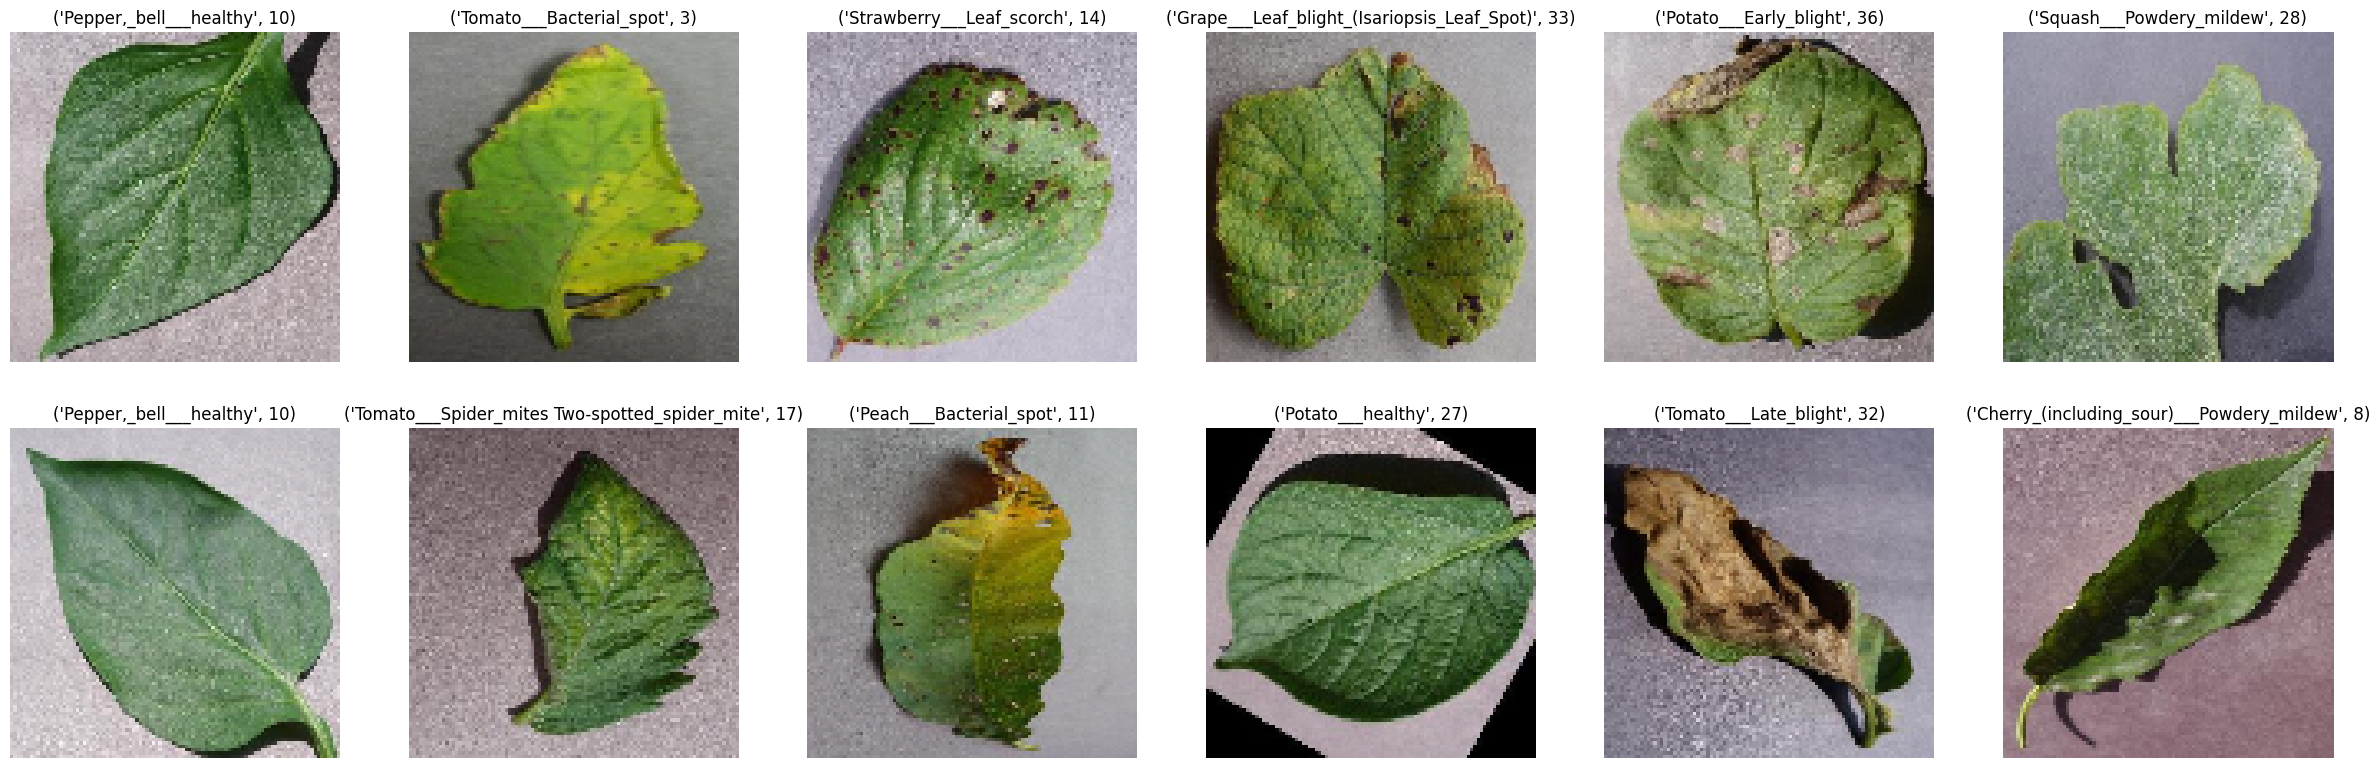

In [ ]:
plt.figure(figsize=(30, 30))
for n, i in enumerate(list(np.random.randint(0, len(train_images), 12))):
    plt.subplot(6, 6, n+1)
    plt.imshow(train_images[i])
    plt.axis('off')
    plt.title(getlabel(train_labels[i]))


We have now plotted some of the images, with their labels and indexes.

In [ ]:
validation_images = []
validation_labels = []

for folder in os.listdir(validation_path):
    files = gb.glob(pathname=str(validation_path + "/" + folder + "/*.JPG")) + \
        gb.glob(pathname=str(validation_path + "/" + folder + "/*.jpg"))
    for file in files:
        img = cv2.imread(file)
        img = cv2.resize(img, (img_size, img_size))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        validation_images.append(list(img))
        validation_labels.append(dataset_labels[folder])


In [ ]:
validation_images, validation_labels = np.array(validation_images), np.array(validation_labels)
validation_images.shape, validation_labels.shape

((17572, 100, 100, 3), (17572,))

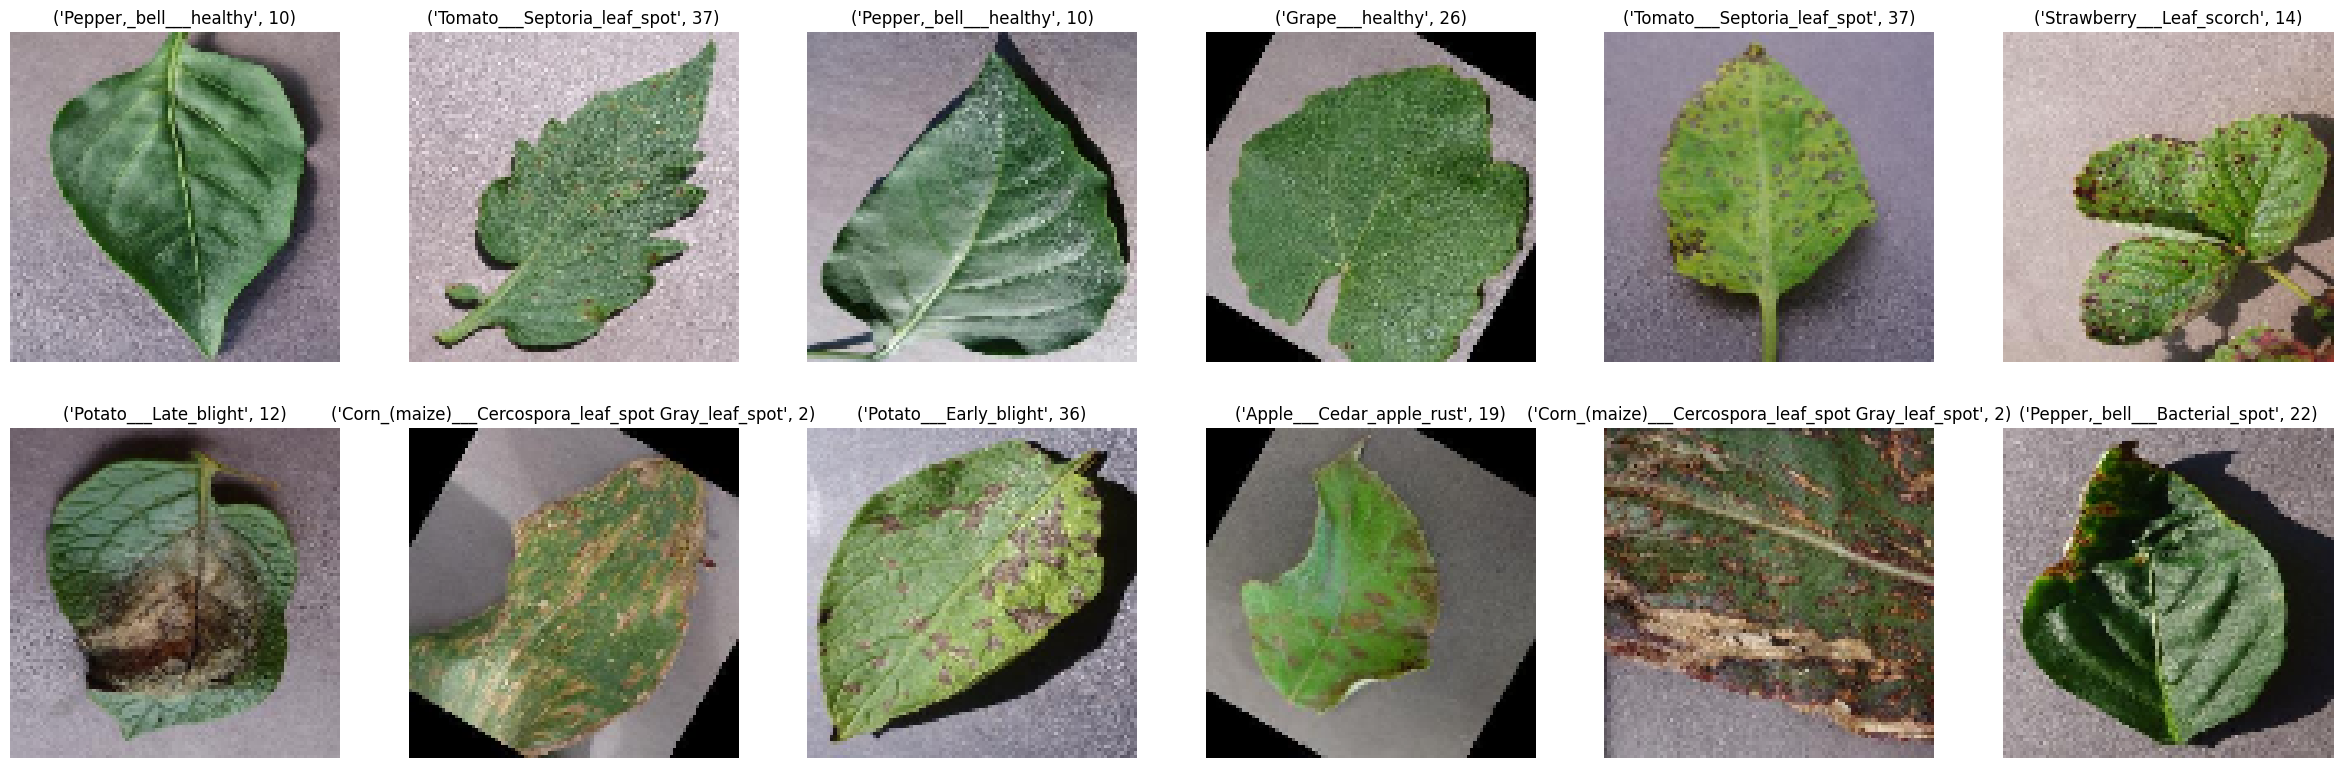

In [ ]:
plt.figure(figsize=(30, 30))
for n, i in enumerate(list(np.random.randint(0, len(validation_images), 12))):
    plt.subplot(6, 6, n+1)
    plt.imshow(validation_images[i])
    plt.axis('off')
    plt.title(getlabel(validation_labels[i]))


In [ ]:
test_images = []

for folder in (os.listdir(test_path)):
    files = gb.glob(pathname=str(test_path + "/" + folder + "/*.JPG")) + \
        gb.glob(pathname=str(test_path + "/" + folder + "/*.jpg"))
    for file in files:
        img = cv2.imread(file)
        img = cv2.resize(img, (img_size, img_size))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        test_images.append(list(img))


In [ ]:
np.array(test_images).shape

(33, 100, 100, 3)

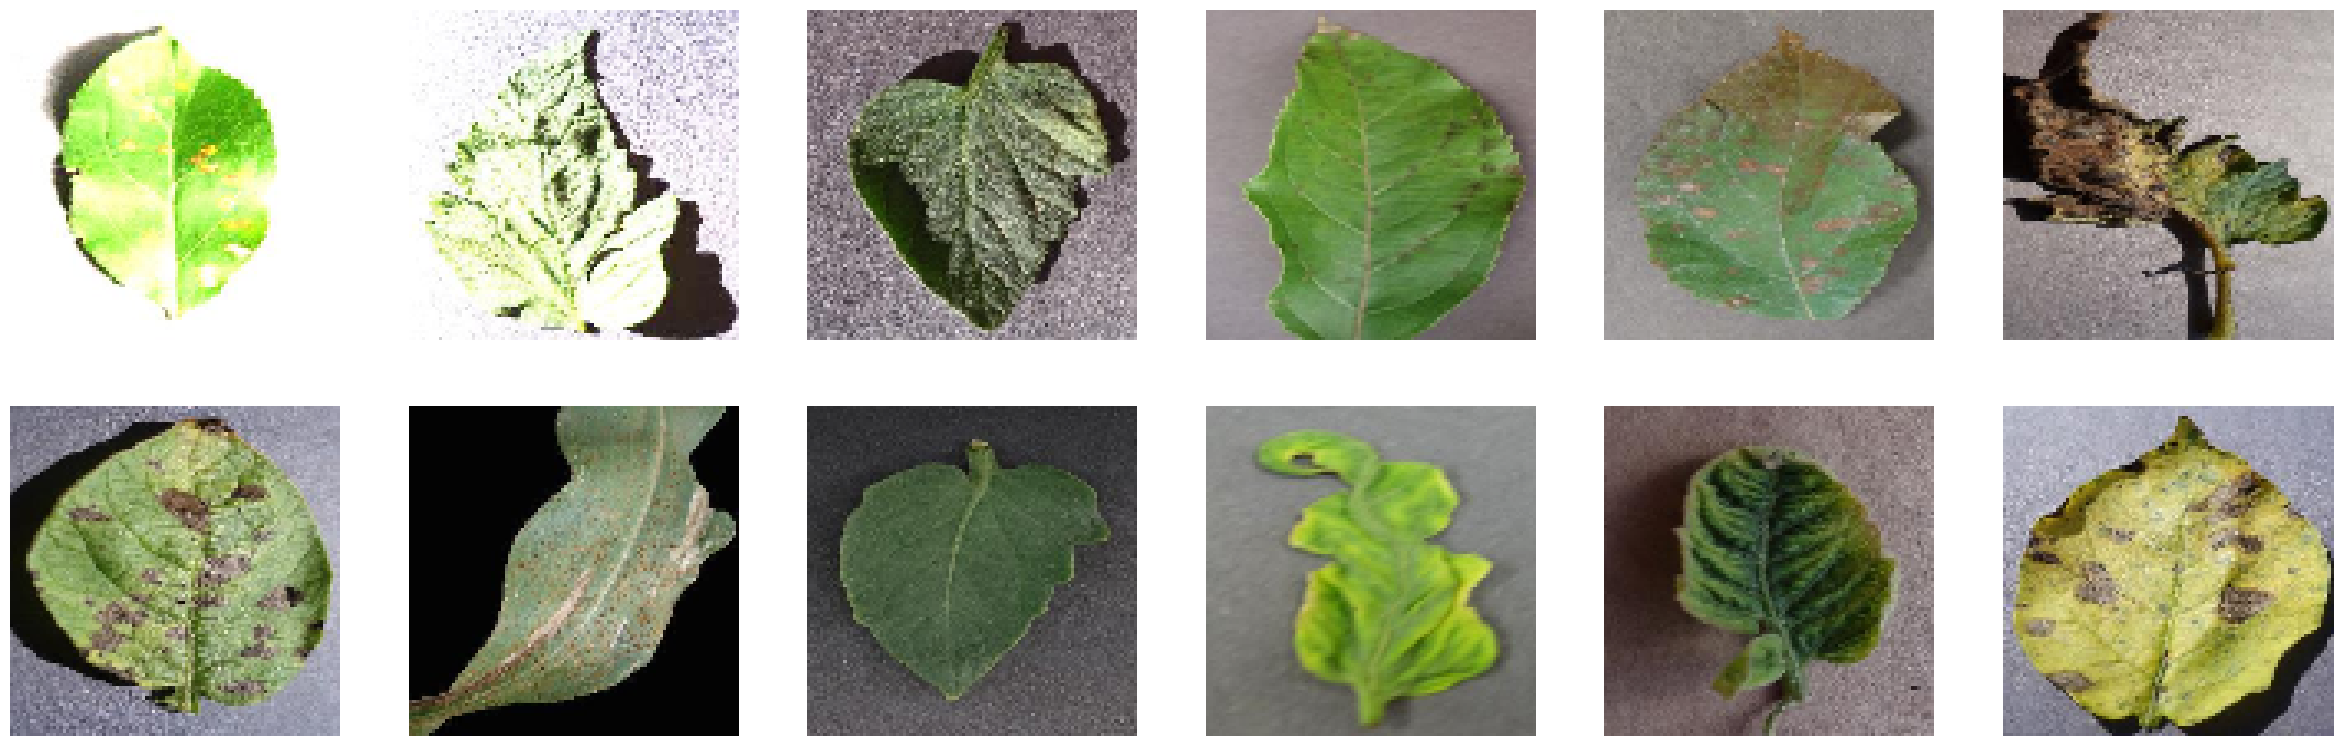

In [ ]:
plt.figure(figsize=(30, 30))
for n, i in enumerate(list(np.random.randint(0, len(test_images), 12))):
    plt.subplot(6, 6, n+1)
    plt.imshow(test_images[i])
    plt.axis('off')


In [ ]:
#initializing train, test and prediction datasets
x_train = train_images
y_train = train_labels
x_test = validation_images
y_test = validation_labels
x_preds = test_images


It's obvious that category of disease, which is of type 'str', cannot be passed directly to our model(as all ML models utilize mathematics). Hence, we will implement 'One-Hot Encoding', which will encode the 'str' type to mappable integers, which can be passed to our neural network.

In [ ]:
#preparing for encoding

# x_train = x_train.astype('float32')
# x_train = x_train / 255

x_test = x_test.astype('float32')
x_test = x_test / 255

x_preds = np.array(x_preds).astype('float32')
x_preds = x_preds / 255

In [ ]:
#Encoding

print(" Shape before one-hot encoding : ", y_train.shape)
y_train = tf.keras.utils.to_categorical(y_train, len(categs))
y_test = tf.keras.utils.to_categorical(y_test, len(categs))
print(" Shape after one-hot encoding : ", y_train.shape)

 Shape before one-hot encoding :  (70295,)
 Shape after one-hot encoding :  (70295, 38)


In [ ]:
model = Sequential([
    Conv2D(32 , kernel_size = (3,3) , activation='relu' , input_shape=(img_size , img_size , 3)) ,
    MaxPool2D(4,4) ,
    Conv2D(64 , kernel_size = (3,3) , activation='relu') ,
    MaxPool2D(4,4) ,
    Flatten() ,
    Dense(128 , activation='relu') ,
    Dense(len(categs) , activation = 'softmax')])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 98, 98, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 24, 24, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 22, 22, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 5, 5, 64)          0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 1600)              0         
                                                                 
 dense (Dense)               (None, 128)               2

In [ ]:
model.compile(Adam(learning_rate=0.001),loss="categorical_crossentropy",metrics=["accuracy"])

In [ ]:
history=model.fit(x_train,y_train,epochs=10,batch_size=64,verbose=1)

Epoch 1/10
1099/1099 [==============================] - 265s 240ms/step - loss: 1.8190 - accuracy: 0.5567
Epoch 2/10
1099/1099 [==============================] - 260s 237ms/step - loss: 0.6006 - accuracy: 0.8143
Epoch 3/10
1099/1099 [==============================] - 264s 241ms/step - loss: 0.4017 - accuracy: 0.8732
Epoch 4/10
1099/1099 [==============================] - 261s 237ms/step - loss: 0.3146 - accuracy: 0.8999
Epoch 5/10
1099/1099 [==============================] - 259s 236ms/step - loss: 0.2745 - accuracy: 0.9125
Epoch 6/10
1099/1099 [==============================] - 260s 237ms/step - loss: 0.2414 - accuracy: 0.9225
Epoch 7/10
1099/1099 [==============================] - 260s 237ms/step - loss: 0.2189 - accuracy: 0.9296
Epoch 8/10
1099/1099 [==============================] - 261s 237ms/step - loss: 0.1980 - accuracy: 0.9367
Epoch 9/10
1099/1099 [==============================] - 260s 237ms/step - loss: 0.1771 - accuracy: 0.9453
Epoch 10/10
1099/1099 [=======================

In [ ]:
model.save('lr_001.h5')

In [ ]:
print(f"The accuracy of the training set is {history.history['accuracy'][-1]:0.2f}")

The accuracy of the training set is 0.95


In [ ]:
print(f"The loss of the training set is {history.history['loss'][-1]:0.2f}")

The loss of the training set is 0.16


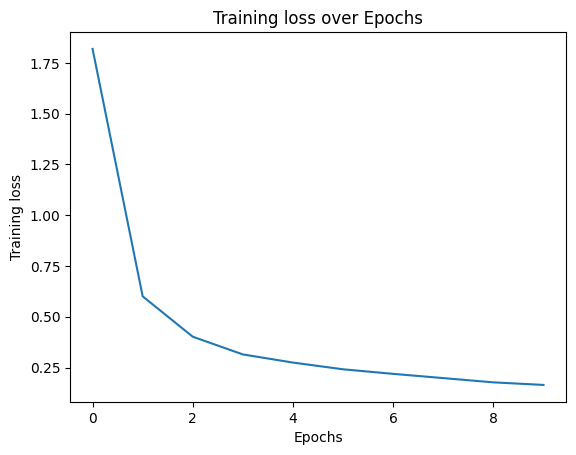

In [ ]:
plt.plot(history.epoch, history.history['loss'])
plt.title('Training loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Training loss')
plt.show()

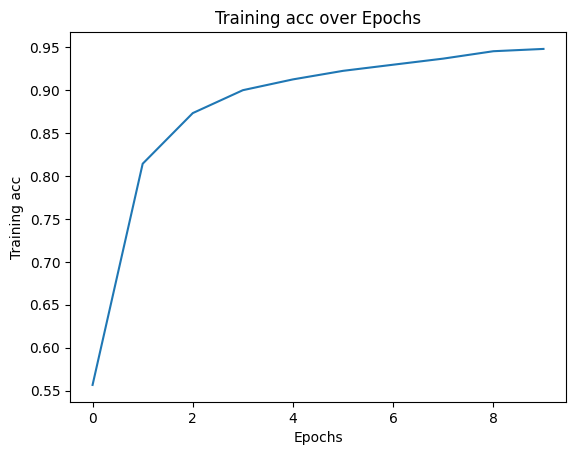

In [ ]:
plt.plot(history.epoch, history.history['accuracy'])
plt.title('Training acc over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Training acc')
plt.show()

In [ ]:
model = keras.models.load_model('lr_001.h5')

In [ ]:
y_preds=model.predict(x_test)

In [ ]:
y_preds=y_preds.round()

In [ ]:
x_preds_labels = []

for folder in (os.listdir(test_path)) :
    for file in os.listdir(test_path + "/" + folder + "/") :
        if os.path.isfile(test_path + "/" + folder + "/" + file) :
            x_preds_labels.append(os.path.splitext(file)[0])

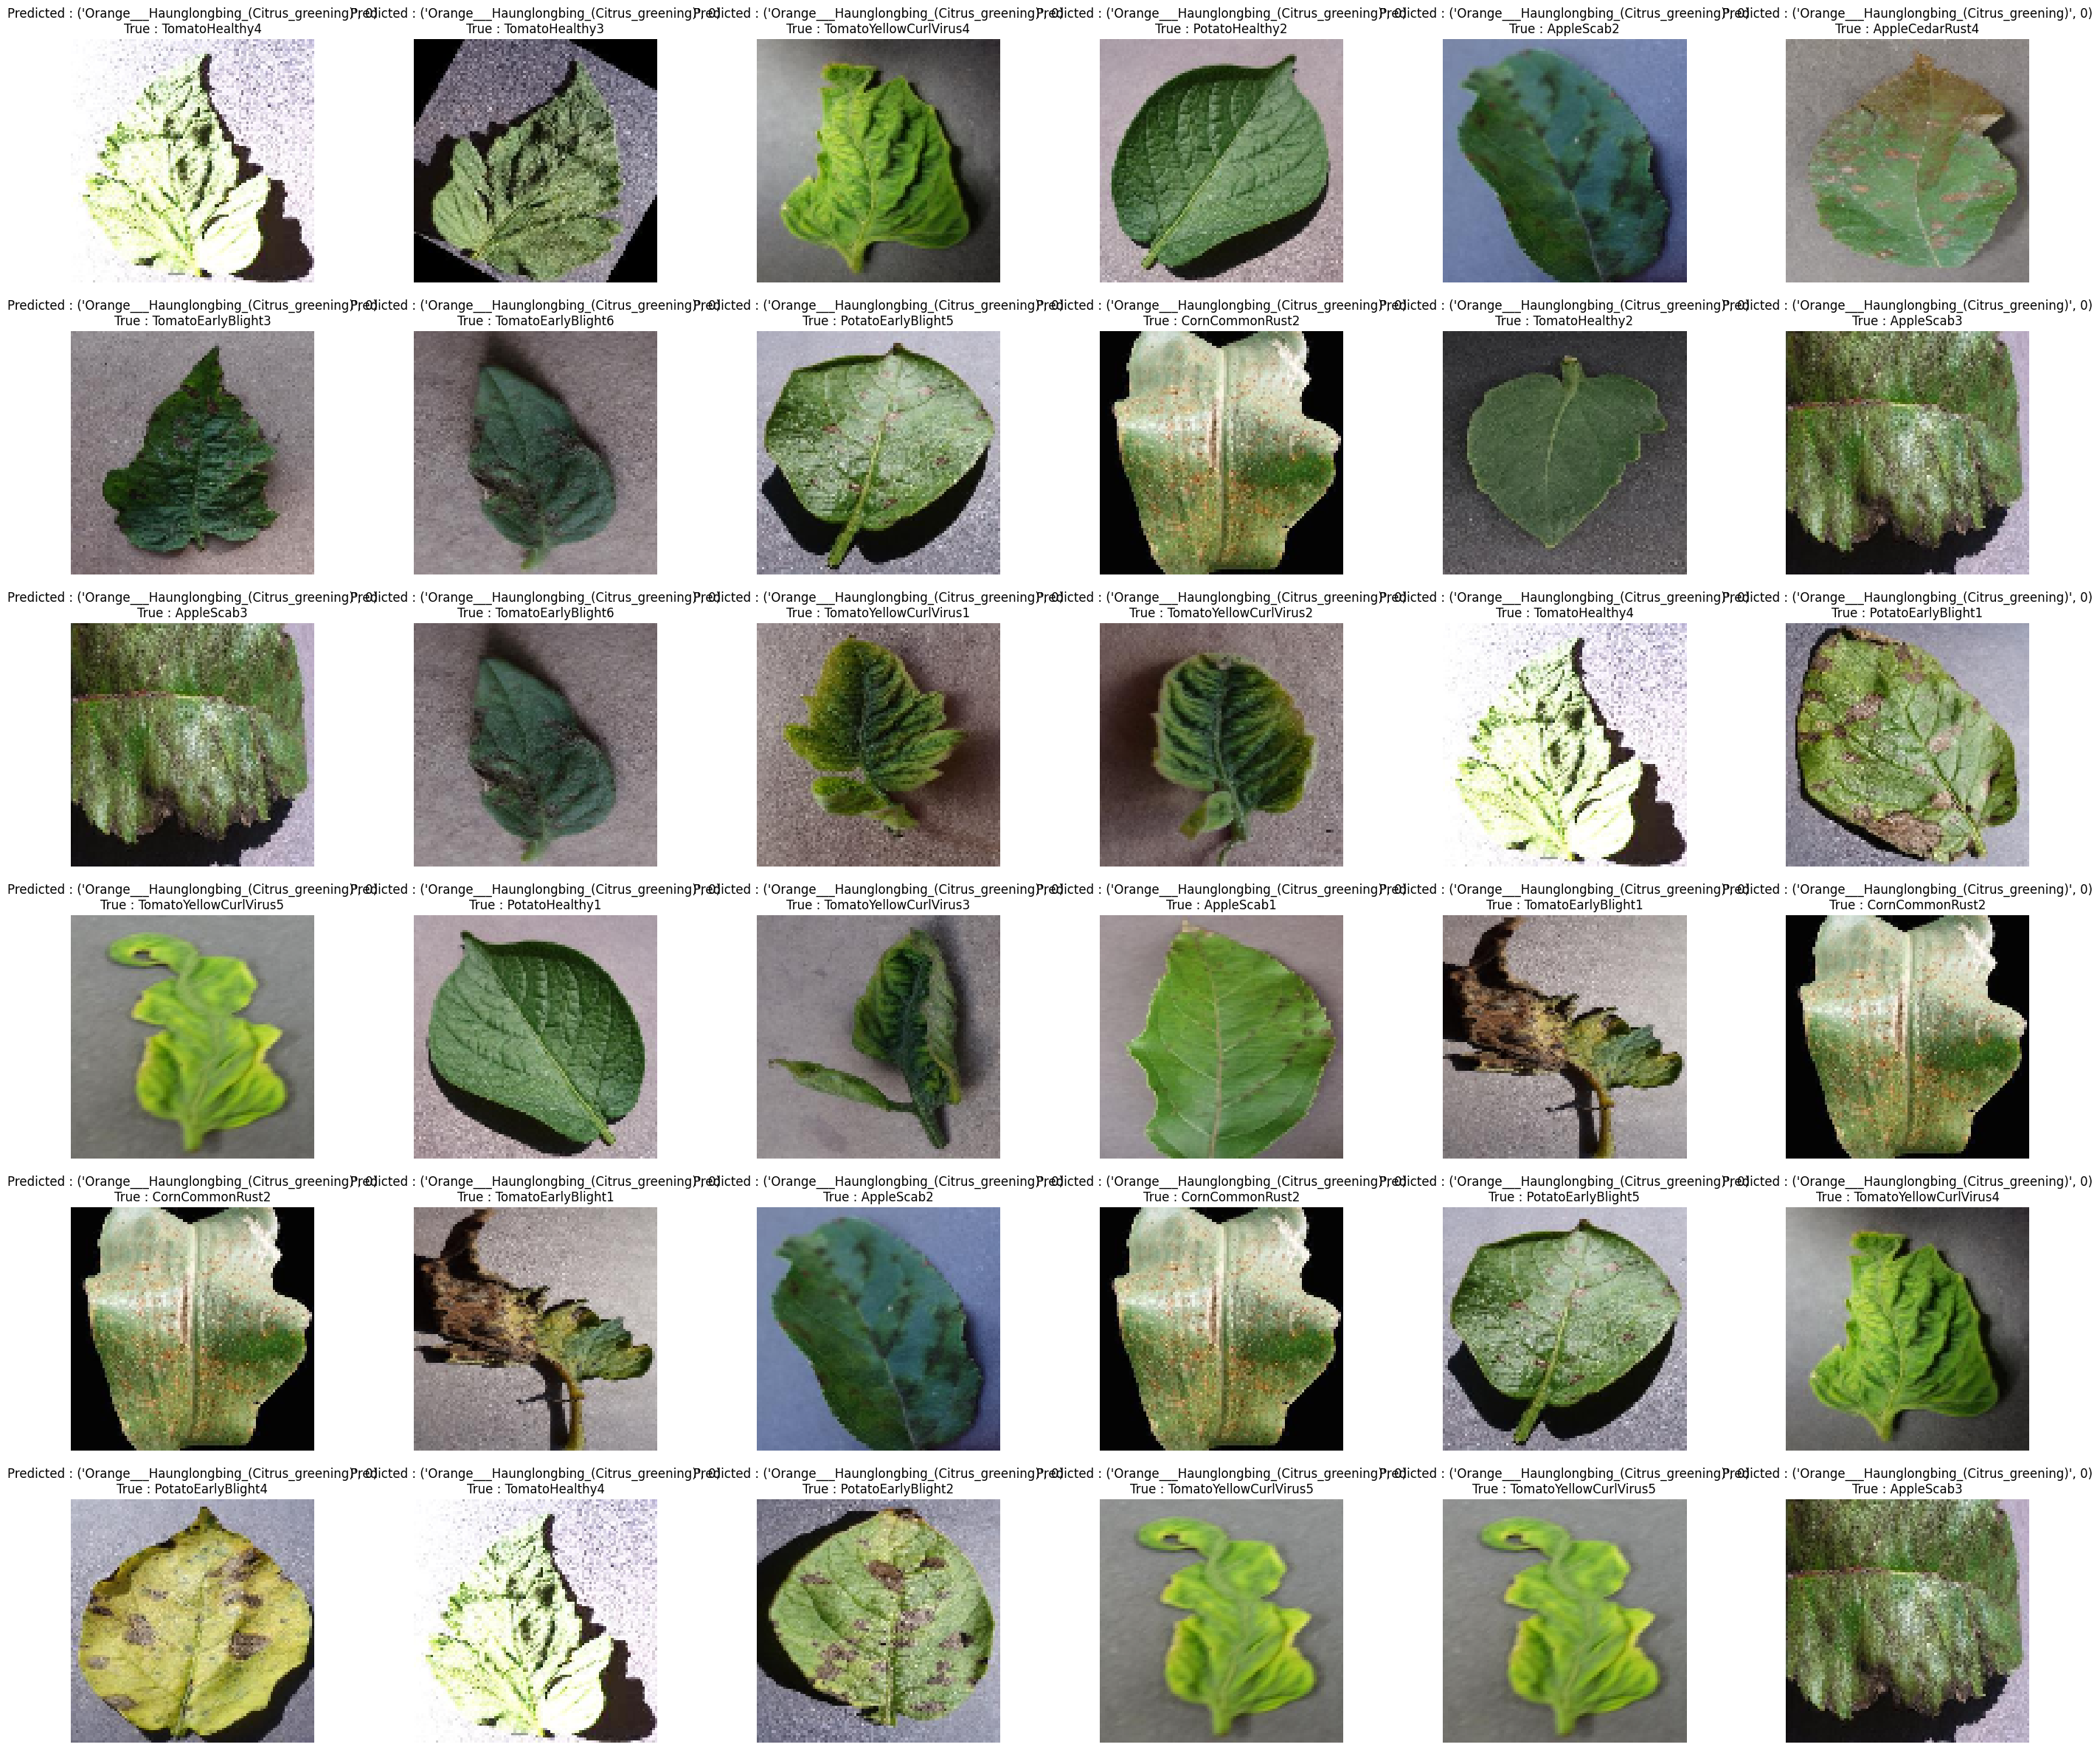

In [ ]:
plt.figure(figsize=(35,30))
for n , i in enumerate(list(np.random.randint(0,len(x_preds),36))) :
    plt.subplot(6,6,n+1)
    plt.imshow(x_preds[i].reshape(img_size,img_size,3),cmap='gray')
    plt.title(f"Predicted : {getlabel(y_preds[i].argmax())}\nTrue : {x_preds_labels[i]}")
    plt.axis('off')